# Introduction

In this notebook, we successfully construct two long-only portfolios that outperform the Dow Jones Industrial Average and the S&P 500 over a one year test period, generating Alphas greater than 15%. We accomplish this by conducting a network analysis that leverages convex optimization across historical returns from more than 4,600 US stocks dating back to January 2, 2015. The motivation for this project was derived primarily from [this Stanford paper](http://snap.stanford.edu/class/cs224w-2015/projects_2015/Network_Analysis_of_the_Stock_Market.pdf). 

We begin by importing necessary packages.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
%matplotlib inline

We then import our historical data from Yahoo! finance by leveraging a comprehensive list of stock symbols generated by [Samir Kahn](http://investexcel.net/all-yahoo-finance-stock-tickers/), represented below in the metadata dataframe. We recommend using the [fix_yahoo_finance](https://pypi.python.org/pypi/fix-yahoo-finance) package when pulling the data. 

In [3]:
metadata.head()

,Name,Exchange,Category
Symbol,,,
^GSPC,S&P 500,SNP,Index
^DJI,Dow Jones Industrial Average,DJI,Index
AAPL,Apple Inc.,NMS,Electronic Equipment
BAC,Bank of America Corporation,NYQ,Money Center Banks
AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses


In particular, we pull adjusted closing prices and keep only those stocks with data for each trading day back to January 2, 2015. A snippet from the resulting dataframe is included below.

In [4]:
data[['AAPL','MSFT','AMZN','^GSPC','^DJI']].head()

,AAPL,MSFT,AMZN,^GSPC,^DJI
Date,,,,,
2015-01-02,103.074181,43.134731,308.519989,2058.199951,17832.99023
2015-01-05,100.170410,42.738068,302.190002,2020.579956,17501.65039
2015-01-06,100.179840,42.110783,295.290009,2002.609985,17371.64063
2015-01-07,101.584595,42.645817,298.420013,2025.900024,17584.51953
2015-01-08,105.487686,43.900375,300.459991,2062.139893,17907.86914


We then calculate log returns and create our training and test sets. Our test set contains a full year of trading data while our training set contains the remaining two years. 

We use our training set to create the correlation matrix that will be leveraged in the construction of our network.     

In [5]:
returns = np.log(data / data.shift(1))[1:]

train = returns[:len(returns)-252]
test = returns[len(returns)-252:]
corr = train.corr()

# Constructing the Network

For our purposes, each node in the network represents a stock, and edges between nodes exist if the correlation of log returns between the two stocks exceeds a given threshold. In our case, we chose a threshold of 50%. The lower one chooses their threshold, the more edges exist, and thus the computation required to analyze the network is increased. Using 50% provides more than 78,000 edges for analysis while preserving computational effeciency on a local machine.  

In [6]:
stocks = list(returns.columns)

G = nx.Graph()
G.add_nodes_from(stocks)
for stock in stocks:
    G.node[stock]['Name'] = metadata.loc[stock, 'Name']
    G.node[stock]['Exchange'] = metadata.loc[stock, 'Exchange']
    G.node[stock]['Category'] = metadata.loc[stock, 'Category']

for first_stock in stocks:
    for second_stock in stocks[stocks.index(first_stock):]:
        if first_stock == second_stock:
            pass
        elif corr.loc[first_stock, second_stock] > 0.5:
            G.add_edge(first_stock, second_stock, weight=corr.loc[first_stock, second_stock])

We visualize the resulting network below using Gephi, color-coding each node according to its industry. 

On the bottom left, we find a disjoint cluster in yellow composed of companies who provide services related to gold, silver, and other precious metals. These companies have highly correlated returns, but their lack of connectivity to the broader network tells us that their returns are uncorrelated with any of the other equities in our universe. 

Conversely, we see a large amalgamation of equities from different industries in the center of our network. This core is comprised primarily of companies in the financial sector. However, consumer goods, basic materials, technology, and services also account for a considerable proportion of the density. 

On the left of the visualization is an orange cluster of biotech companies whose connection with the central mass is weaker, though still existent via a few bridge equities. Similarly, the cluster of blue, pink, and green at the top of the network represent non-utility energy companies (i.e., oil and gas) covering the value chain from extraction to marketing and sales. 

Finally, the multi-industry cluster on the bottom right is comprised primarily of utilities and REITs. 

![Network](Network.png)

With the network constructed and visualized, we then calculate the normalized centrality measures for each node and assign them accordingly. 

In network analysis, centrality measures are meant to identify "important" nodes. However, what importance means within a network isn't always obvious. Thus, there are a variety of centrality measures, each representing different node attributes. 

The simplest centrality measure is degree centrality, which quantifies the number of edges connected to each node. In our case, stocks with high degree centrality are correlated with many other stocks, suggesting they could serve as useful representatives of those stocks within a portfolio. 

Slightly more complex are closeness and betweenness centrality. Closeness quantifies the average length of the shortest path between a node and all other nodes in the network while betweenness quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Thus, stocks with high closeness centralities tend to be centralized within the network whereas those with high betweenness centralities tend to serve as bridges between groups of similarly performing stocks. 

While their calculations are substantially different, these three measures tend to be correlated. When they aren't, that may mean something interesting. For example, a stock with high degree centrality but low closeness centrality is likely a useful representative within a remote cluster of similarly performing stocks. 

In [7]:
deg_cent = pd.Series(nx.degree_centrality(G))
between_cent = pd.Series(nx.betweenness_centrality(G))
closeness_cent = pd.Series(nx.closeness_centrality(G))

cent = pd.concat([deg_cent, between_cent, closeness_cent], axis=1)
cent.columns = ['D_cent','B_cent','C_cent']

# Normalize the centralities using min-max
normalized_cent = (cent - cent.min()) / (cent.max() - cent.min())

for stock in stocks:
    for col in normalized_cent.columns:
        G.node[stock][col] = float(normalized_cent.loc[stock, col])

At this point, the Stanford group reasoned that to match the performance of the market they should select stocks that are representative of the market itself. This naturally led them to use centrality measures as the criteria for stock selection. In particular, they sought to optimize the weights assigned to each centrality measure in order to maximize the return of the resulting portfolio. This method identified a portfolio that marginally outperformed the S&P 500 over a three year period using only one year of training data, though no additional detail is provided in the paper. 

While impressive, we felt that the Stanford group's method could be further improved by incorporating an important concept in effective portfolio management: diversification. 

To accomplish this, we devised two alternative methods. The first finds disjoint cliques within the network and selects a representative stock from each. The second finds top performing stocks with no connections within the network. 

However, before jumping into each method, let's first define some useful functions to simulate and assess the performance of our portfolios.

# Some Useful Functions

To start, we modify a function from [Thomas Wiecki, Thomas Starke, and David Edwards](https://blog.quantopian.com/markowitz-portfolio-optimization-2/) that uses quadratic programming to calculate the Markowitz efficient frontier given our selected stocks as inputs. For additional background on quadratic programming, check out [Chapter 4 Section 7 of Convex Optimization by Stephen Boyd and Lieven Vandenberghe](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf).

In [8]:
import cvxopt as opt
from cvxopt import blas, solvers

# Turn off progress printing 
solvers.options['show_progress'] = False

def optimal_portfolio(stocks, returns):
    n = len(returns)
    rets = np.asmatrix(returns)
    
    # Create a non-linear grid of 10,000 scalars from 0.1 to 10,000 
    # These scalars serve as weights placed on risk in each optimization
    # -- the larger they are, the more we want risk to be minimized
    N = 10000
    mus = [10 ** (5.0 * t/N - 1.0) for t in range(N+1)]
    
    # Convert returns to cvxopt matrices
    S = opt.matrix(np.cov(rets))                # n x n dense float matrix
    pbar = opt.matrix(np.mean(rets, axis=1))  # n x 1 dense float matrix
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n dense integer identity matrix
    h = opt.matrix(0.0, (n ,1)) # n x 1 dense integer matrix with zeros
    A = opt.matrix(1.0, (1, n)) # 1 x n dense integer matrix with ones
    b = opt.matrix(1.0)         # 1 x 1 dense integer matrix containing one
    
    # The solver is going to use the negative mean return and positive covariance
    # since we're trying to maximize return while minimizing variance
    #   Minimizing: −pbar.T*x + µ*x.T*Σ*x
    #   subject to 1.T*x = 1, x >= 0
    #   where x is the (nx1) vector of weights for each asset within the portfolio 
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    # Calculate risks and returns for frontier
    rets = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    
    # Combine everything into a nice dataframe
    df = pd.DataFrame({x: [weight for weight in portfolios[x]] for x in range(len(portfolios))}).T
    df = df.merge(pd.DataFrame(np.asarray(rets) * 100), left_index=True, right_index=True)
    df = df.merge(pd.DataFrame(np.asarray(risks) * 100), left_index=True, right_index=True)
    df.columns = [stocks + ['means','stds']]
    df.columns = df.columns.map(''.join)        # Fix the multilevel index
    df['sharpes'] = (df.means - benchmark_return) / df.stds * np.sqrt(252)
    
    return df

The plot_simulations function will then create a scatter plot of the efficient frontier color-coded by Sharpe ratio, with the best portfolio highlighted in blue. This function also plots the allocations for each portfolio along the efficient frontier. 

In [9]:
def plot_simulations(ef_results, best_sharpe_index, stocks):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(8)
    
    # Efficient Frontier
    ef_plot = ax1.scatter(x=ef_results['stds'], y=ef_results['means'], c=ef_results['sharpes'], cmap='RdYlGn')
    plt.colorbar(ef_plot, ax=ax1)
    ax1.scatter(x=ef_results.loc[best_sharpe_index,'stds'], y=ef_results.loc[best_sharpe_index,'means'], c='blue', marker='D', 
                s=100)
    ax1.set_ylabel('Mean Expected Daily Return (%)')
    ax1.set_xlabel('Daily Risk (%)')
    ax1.set_title('Efficient Frontier')
    
    # Allocation Plot
    ax2.stackplot(ef_results['means'], ef_results[stocks].T.values * 100, colors=plt.cm.tab20(np.linspace(0,1,20)))
    ax2.axvline(ef_results.loc[best_sharpe_index, 'means'], c='blue')

    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(['Portfolio'] + stocks, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    ax2.set_ylabel('Allocations (%)')
    ax2.set_xlabel('Mean Expected Daily Return (%)')
    ax2.set_title('Allocation Plot')

    fig.tight_layout()
    plt.show()

The forward_test function will then take the list of selected stocks and their optimal weights found via the efficient frontier as inputs and produce a line plot of the portfolio's performance vs. the Dow Jones Industrial Average and the S&P 500. This function also creats supplemental plots showing the relative performance of the market indices vs. the portfolio and the contribution of each component stock in the portfolio. 

In [10]:
def forward_test(stocks, optimal_weights):
    forward_test = optimal_weights * test[stocks]
    forward_test['Portfolio'] = forward_test.sum(axis=1)
    forward_test[['^DJI','^GSPC']] = test[['^DJI','^GSPC']]

    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(221) 
    ax2 = plt.subplot(223) 
    ax3 = plt.subplot(122) 
    
    # Cumulative Returns
    ax1.plot(forward_test[['Portfolio','^DJI','^GSPC']].cumsum() * 100)
    ax1.legend(['Portfolio','^DJI','^GSPC'])
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.set_title('Forward Test of Network Portfolio vs. Market Indices')
    
    # Relative Returns by Month
    monthly_forward_test = forward_test.resample('M').sum() * 100
    date_index = monthly_forward_test.index.date
    ind = np.arange(len(date_index))
    width = 0.3
    
    rel_ret_df = monthly_forward_test[['^DJI','^GSPC']].sub(monthly_forward_test['Portfolio'], axis=0)
    ax2.bar(ind, rel_ret_df['^DJI'], width, color='orange')
    ax2.bar(ind + width, rel_ret_df['^GSPC'], width, color='green')
    
    ax2.legend(['^DJI','^GSPC'], loc='best')
    ax2.set_xticks(ind + width)
    ax2.set_xticklabels([d.strftime('%Y-%m') for d in date_index], rotation=45)
    ax2.set_ylabel('Relative Return (%)')
    ax2.set_title('Relative Performance of Market Indices vs. Portfolio')
    
    # Contribution of each stock w/in the Portfolio
    ax3.set_prop_cycle('color', plt.cm.tab20(np.linspace(0,1,20)))
    ax3.plot(forward_test[stocks].cumsum() * 100)
    ax3.legend(stocks, ncol=2)
    ax3.set_ylabel('Weighted Cumulative Return (%)')
    ax3.set_title('Contribution of Each Stock in the Portfolio')
    
    fig.tight_layout()
    plt.show()

Finally, we construct four functions used to calculate [traditional measures of portfolio performance: the Sharpe Ratio, the Treynor Ratio, and Jensen's Alpha](https://www.investopedia.com/articles/08/performance-measure.asp). 

The Sharpe Ratio calculates the annualized risk-adjusted return of an asset or portfolio of assets; the Treynor Ratio calculates the annualized excess return that a portfolio generates over that which could have been earned on an investment that has no diversifiable risk; and Jensen's Alpha calculates the annualized excess return that a portfolio generates over its expected return. 

To better understand these metrics, we refer readers to the [capital asset pricing model (CAPM)](https://en.wikipedia.org/wiki/Capital_asset_pricing_model). 

In all cases, we use an annual risk-free return of 5% as our benchmark.

In [11]:
benchmark_return = (1 + 0.05) ** (1 / 252) - 1

# Beta indicates whether a portfolio is more or less volatile than the market as a whole
def calc_beta(portfolio, market):
    return round(np.cov(portfolio, test[market])[0,1] / np.cov(portfolio, test[market])[1,1], 3)

# Sharpe Ratio
def calc_sharpe(stock, benchmark):
    return round((train[stock].mean() - benchmark) / train[stock].std() * np.sqrt(252), 3)

# Treynor Ratio
def calc_treynor(portfolio, market, benchmark):
    beta = calc_beta(portfolio, market) 
    daily_treynor = (portfolio.mean() - benchmark) / beta
    return round(((1 + daily_treynor) ** 252 - 1) * 100, 3)

# Jensen's Alpha
def calc_jensen(portfolio, market, benchmark):
    beta = calc_beta(portfolio, market)
    expected_return = benchmark + beta * (test[market].mean() - benchmark)
    daily_alpha = portfolio.mean() - expected_return
    return round(((1 + daily_alpha) ** 252 - 1) * 100, 3)

With these functions in hand, we can introduce our first method using disjoint cliques. 

# Disjoint Clique Method

The idea is straightforward: identify all disjoint maximal cliques with at least three members, then select a stock from each with the highest aggregated centrality score and a cumulative return exceeding 10% over the two year training period. From this list, pick the top 20 according to Sharpe ratio. 

In this context, a maximal clique is a group of nodes where each node is connected to every other node, and no additional node can be added such that it would also be fully connected. 

Using a correlation threshold of 50% yielded 73 disjoint cliques of size three or greater for our analysis. 

In [12]:
maximal_cliques = sorted(list(nx.find_cliques(G)), key=len)
m_cliques = [c for c in maximal_cliques if len(c) >= 3]
dc_stocks = []

while m_cliques:
    clique = m_cliques.pop()
    overlapping_cliques = [clique] + [c for c in m_cliques if any(i in c for i in clique)]
    o_union = list(set().union(*overlapping_cliques))
    o_dict = {stock: G.node[stock]['D_cent'] + G.node[stock]['B_cent'] + G.node[stock]['C_cent'] 
              for stock in o_union}
    
    for stock in pd.Series(o_dict).sort_values(ascending=False).index:
        if train[stock].cumsum()[-1] > 0.1 and stock not in ['^DJI','^GSPC']:
            dc_stocks.append(stock)
            break
    
    m_cliques = [c for c in m_cliques if not any(i in c for i in clique)]
    
dc_sharpes = calc_sharpe(dc_stocks, benchmark_return)            
top_dc_stocks = list(dc_sharpes.nlargest(20).index)

The visualization below color-codes the network according to the disjoint cliques we just found, with the selected stocks enlarged for emphasis. 

![DC Method](Disjoint Clique Method.png)

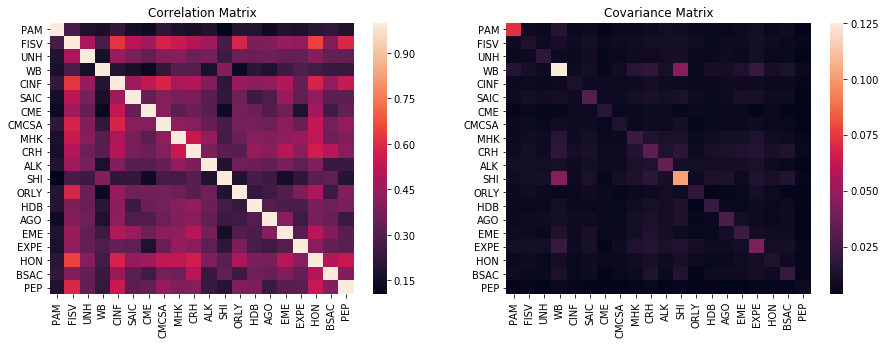

In [13]:
# Plot a heatmap of the correlation and covariance matrices for selected stocks
def compare_stocks(stocks):
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    sns.heatmap(train[stocks].corr(), ax=ax1)
    ax1.set_title('Correlation Matrix')
    sns.heatmap(train[stocks].cov() * 100, ax=ax2)
    ax2.set_title('Covariance Matrix')
    plt.show()

compare_stocks(top_dc_stocks)

With our stocks selected, we then calculate the efficient frontier and assess the corresponding allocation plot. 

In this case, the largest Sharpe ratio along the efficient frontier was 2.1. We also note that despite selecting 20 stocks for our portfolio, the efficient frontier allocates the entire portfolio to just seven stocks. 

In [14]:
dc_ef_results = optimal_portfolio(top_dc_stocks, train[top_dc_stocks].T.values)
best_dc_sharpe_index = np.argmax(dc_ef_results['sharpes'].values)
optimal_dc_weights = dc_ef_results.iloc[best_dc_sharpe_index].loc[top_dc_stocks]

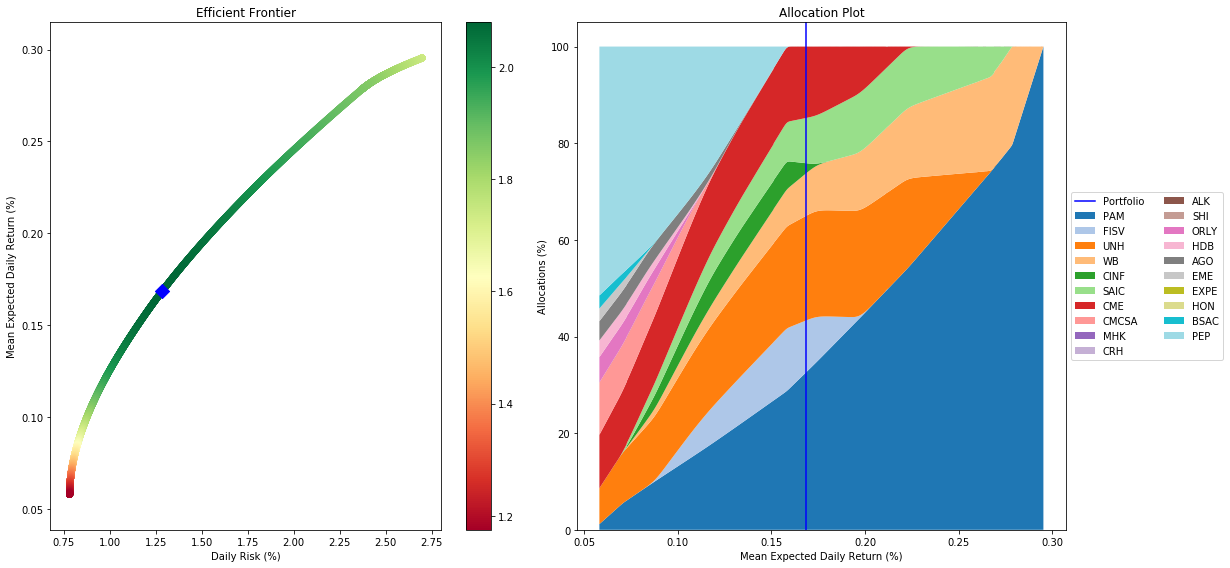

In [15]:
plot_simulations(dc_ef_results, best_dc_sharpe_index, top_dc_stocks)

Finally, we forward test the optimal portfolio from this method against the Dow Jones Industrial Average and the S&P 500. 

As can be seen in the chart, our disjoint clique method produces a portfolio that ultimately outperforms both indices. In fact, our Alpha using the S&P 500 and a 5% risk free rate is 16.1% over the test period. However, we also note that this portfolio underperforms both indices three months of out of twelve assessed and is 5% more volatile than the S&P 500. 

We'll keep the resulting Treynor Ratio of 27 in our back pocket for future reference. 

In [16]:
dc_portfolio = (test[top_dc_stocks] * optimal_dc_weights).sum(axis=1)
print("Alpha: " + str(calc_jensen(dc_portfolio, '^GSPC', benchmark_return)))
print("Beta: " + str(calc_beta(dc_portfolio, '^GSPC')))
print("Treynor Ratio: " + str(calc_treynor(dc_portfolio, '^GSPC', benchmark_return)))

Alpha: 16.093
Beta: 1.05
Treynor Ratio: 27.003


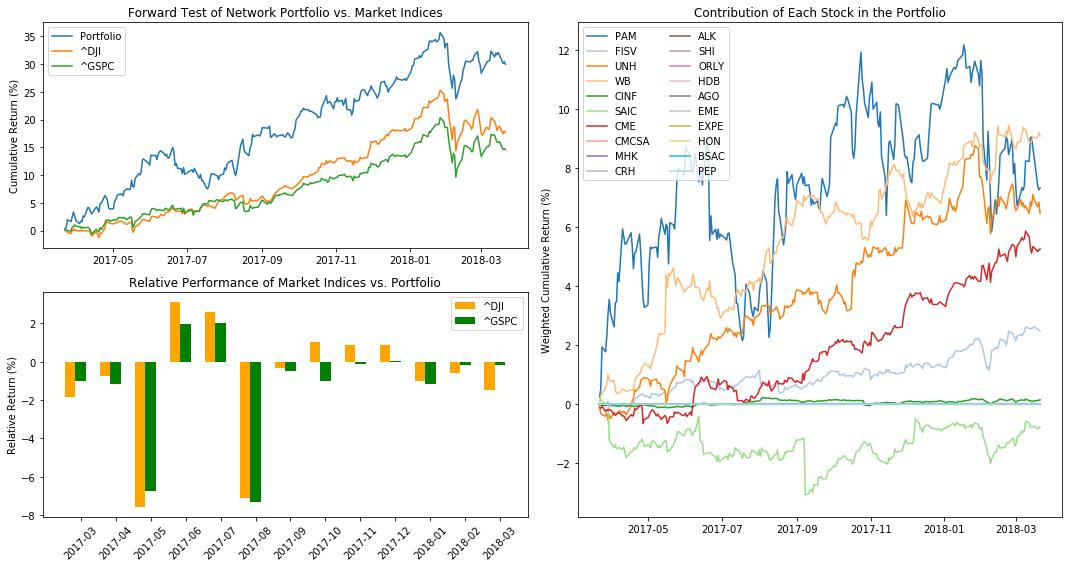

In [17]:
forward_test(top_dc_stocks, optimal_dc_weights)

# Zero Centrality Method

Our second method is arguably even more straightforward: filter the universe of stocks down to those with no connections to the rest of the network, and then sort according to their Sharpe ratio over the training period. 

The selection method ensures minimal correlation and thus ample diversification while prioritizing historical performance. Of course, a large concern is that historical performance is not always indicative of future performance. However, this approach can be easily applied on a regular basis to rebalance as necessary. 

In [18]:
zc_stocks = normalized_cent[normalized_cent == 0].dropna().index

zc_sharpes = calc_sharpe(zc_stocks, benchmark_return)
top_zc_stocks = list(zc_sharpes.nlargest(20).index)

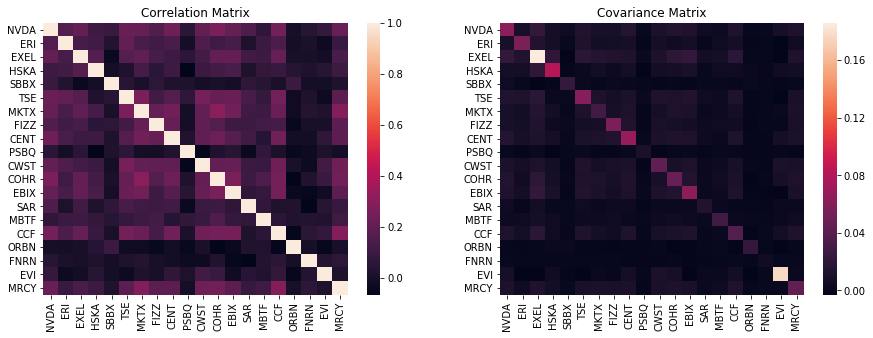

In [19]:
# Plot a heatmap of the correlation and covariance matrices for selected stocks
compare_stocks(top_zc_stocks)

Again, we calculate the efficient frontier and examine the allocations across portfolios. 

In this case, our optimal portfolio achieved a Sharpe ratio greater than 4.95 -- extremely impressive, especially considering no additional research went into the selection methodology. Moreover, our portfolio is well diversified across almost all 20 stocks based on our allocation plot. 

In [20]:
zc_ef_results = optimal_portfolio(top_zc_stocks, train[top_zc_stocks].T.values)
best_zc_sharpe_index = np.argmax(zc_ef_results['sharpes'].values)
optimal_zc_weights = zc_ef_results.iloc[best_zc_sharpe_index].loc[top_zc_stocks]

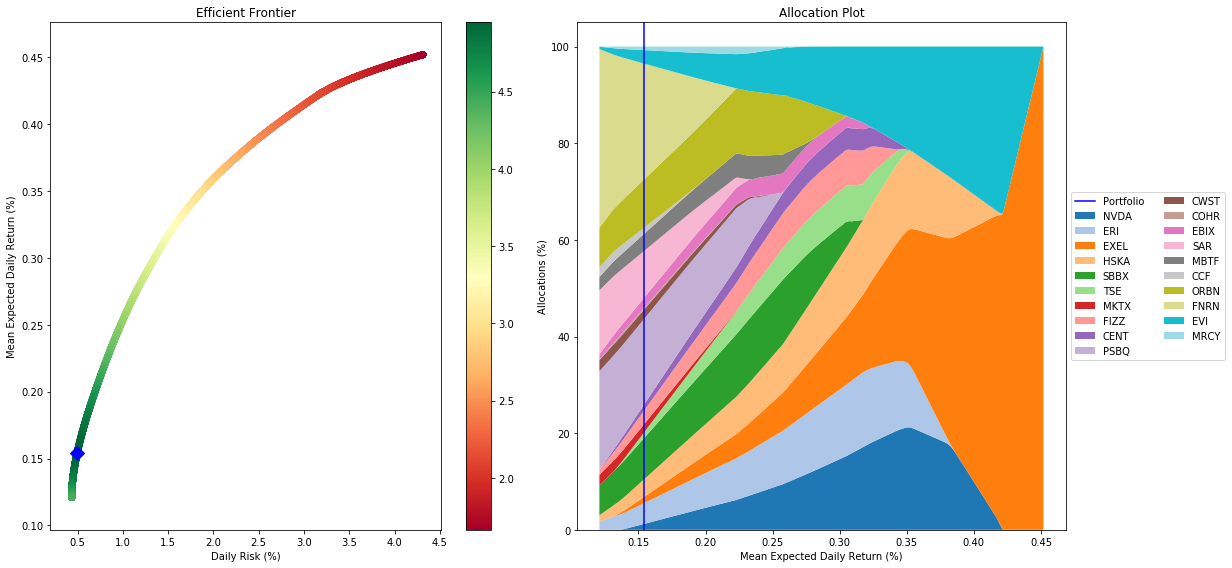

In [21]:
plot_simulations(zc_ef_results, best_zc_sharpe_index, top_zc_stocks)

When forward testing our zero centrailtiy portfolio against the market indices we observe more consistent outperformance, this time only underperforming both indices two months out of the twelve assessed. However, this portfolio's Alpha is 1% lower than the disjoint clique portfolio over the test period, and its cumulative log return is 10% lower. 

Despite these facts, we note that the zero centrality portfolio's Beta of 0.37 is 280% lower than the disjoint clique method and may therefore be more attractive to a risk-adverse investor. This point is made clearer when comparing both portfolios' Treynor Ratios. In particular, the zero centrality portfolio is able to generate 2.3 times more return per unit of risk than the disjoint clique method. 

In [22]:
zc_portfolio = (test[top_zc_stocks] * optimal_zc_weights).sum(axis=1)
print("Alpha: " + str(calc_jensen(zc_portfolio, '^GSPC', benchmark_return)))
print("Beta: " + str(calc_beta(zc_portfolio, '^GSPC')))
print("Treynor Ratio: " + str(calc_treynor(zc_portfolio, '^GSPC', benchmark_return)))

Alpha: 15.103
Beta: 0.365
Treynor Ratio: 61.932


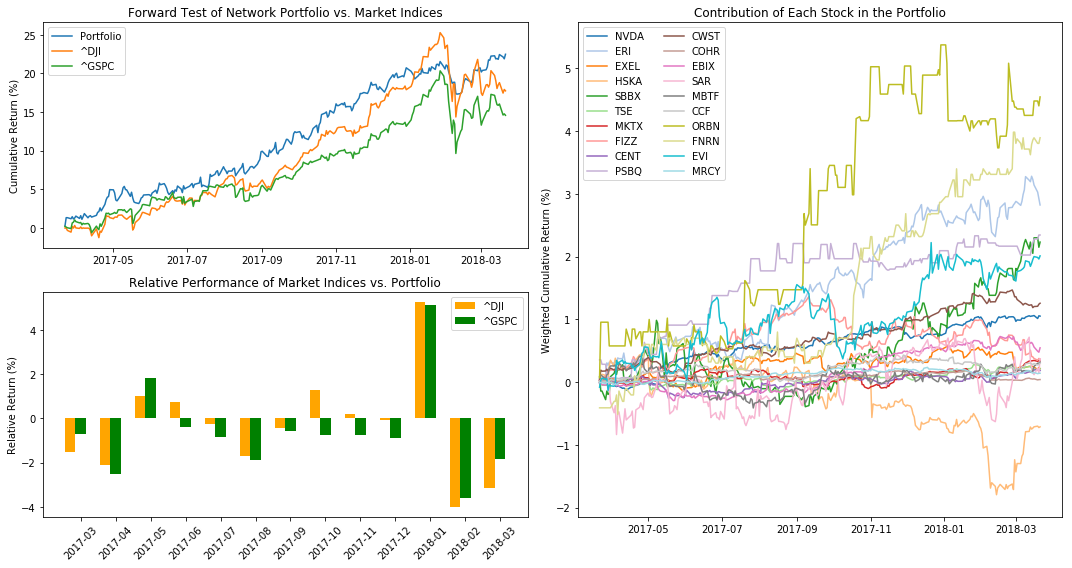

In [23]:
forward_test(top_zc_stocks, optimal_zc_weights)

# Value at Risk and Expected Shortfall

With both portfolios assessed, we next calculate the one day 99% value at risk and expected shortfall for both portfolios and compare them to the one day 99% value at risk and expected shortfall for both market indices. 

For simplicity, we simulate 10,000 next-day prices by sampling returns from a normal distribution. 

In [24]:
initial_investment = 1000000

def simulate_VaRs(stocks, optimal_weights, n_simulations):
    prices = {stock: data.iloc[len(data)-252][stock] for stock in stocks}
    shares = {stock: int(optimal_weights.loc[stock] * initial_investment / prices[stock]) for stock in stocks}
    
    VaRs = []
    for simulation in range(n_simulations):
        daily_changes = {}
        for stock in stocks:
            f_return = np.random.normal(train[stock].mean(), train[stock].std())
            f_price = np.exp(f_return + np.log(prices[stock]))
            daily_changes.update({stock: (f_price - prices[stock]) * shares[stock]})
        VaRs.append(sum(daily_changes.values()) / initial_investment * 100)
        
    VaR = np.percentile(VaRs, 0.99)
    ES = np.mean([x for x in VaRs if x <= VaR])
    
    return VaRs, VaR, ES

In [25]:
dc_VaRs, dc_VaR, dc_ES = simulate_VaRs(top_dc_stocks, optimal_dc_weights, 10000)
zc_VaRs, zc_VaR, zc_ES = simulate_VaRs(top_zc_stocks, optimal_zc_weights, 10000)
DJI_VaRs, DJI_VaR, DJI_ES = simulate_VaRs(['^DJI'], pd.Series(1, index=['^DJI']), 10000)
GSPC_VaRs, GSPC_VaR, GSPC_ES = simulate_VaRs(['^GSPC'], pd.Series(1, index=['^GSPC']), 10000)

Our disjoint clique portfolio produces a higher one day 99% VaR and expected shortfall than the Dow Jones Industrial Average and the S&P 500 while our zero centrality portfolio produces the opposite, again reflecting the relative risk exposure of each portfolio. 

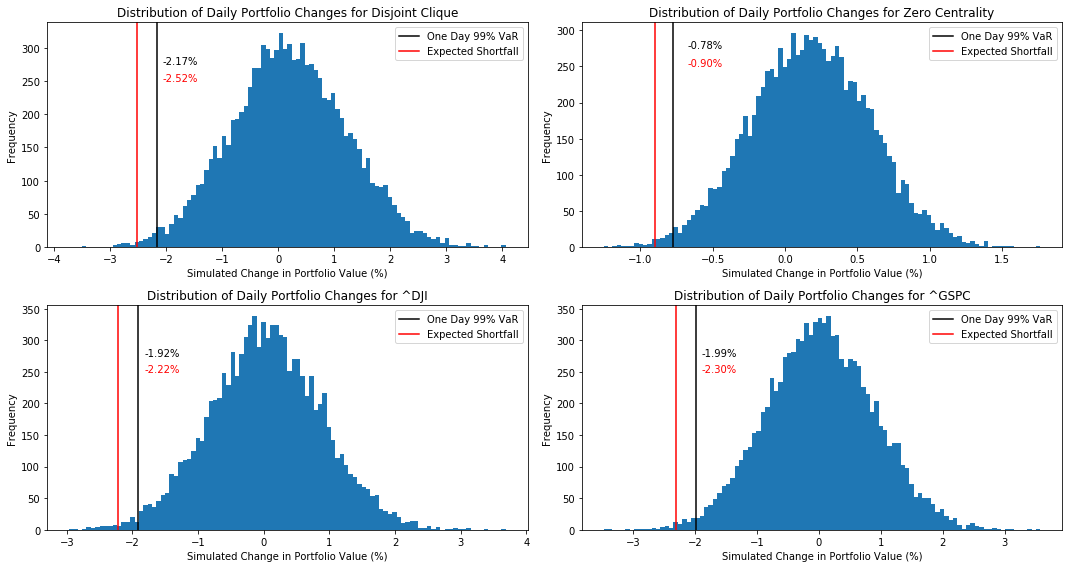

In [26]:
def plot_hist(ax, portfolio, VaRs, VaR, ES):
    ax.hist(VaRs, bins=100)
    ax.axvline(VaR, color='k')
    ax.text(VaR + 0.1, 275, '{:,.2f}%'.format(VaR))
    ax.axvline(ES, color='red')
    ax.text(VaR + 0.1, 250, '{:,.2f}%'.format(ES), color='red')
    ax.set_xlabel('Simulated Change in Portfolio Value (%)')
    ax.set_ylabel('Frequency')
    ax.legend(['One Day 99% VaR','Expected Shortfall'])
    ax.set_title('Distribution of Daily Portfolio Changes for ' + portfolio)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(8)
plot_hist(ax1, 'Disjoint Clique', dc_VaRs, dc_VaR, dc_ES)
plot_hist(ax2, 'Zero Centrality', zc_VaRs, zc_VaR, zc_ES)
plot_hist(ax3, '^DJI', DJI_VaRs, DJI_VaR, DJI_ES)
plot_hist(ax4, '^GSPC', GSPC_VaRs, GSPC_VaR, GSPC_ES)
plt.tight_layout()
plt.show()

# Conclusion

To wrap things up, we apply both methods to the most recent two years of data and observe the resulting portfolio selections. We only show the results for this step, as the code to produce the results is the same as above. These would be the long-only positions to take as of March 22, 2018 when the data was pulled. 

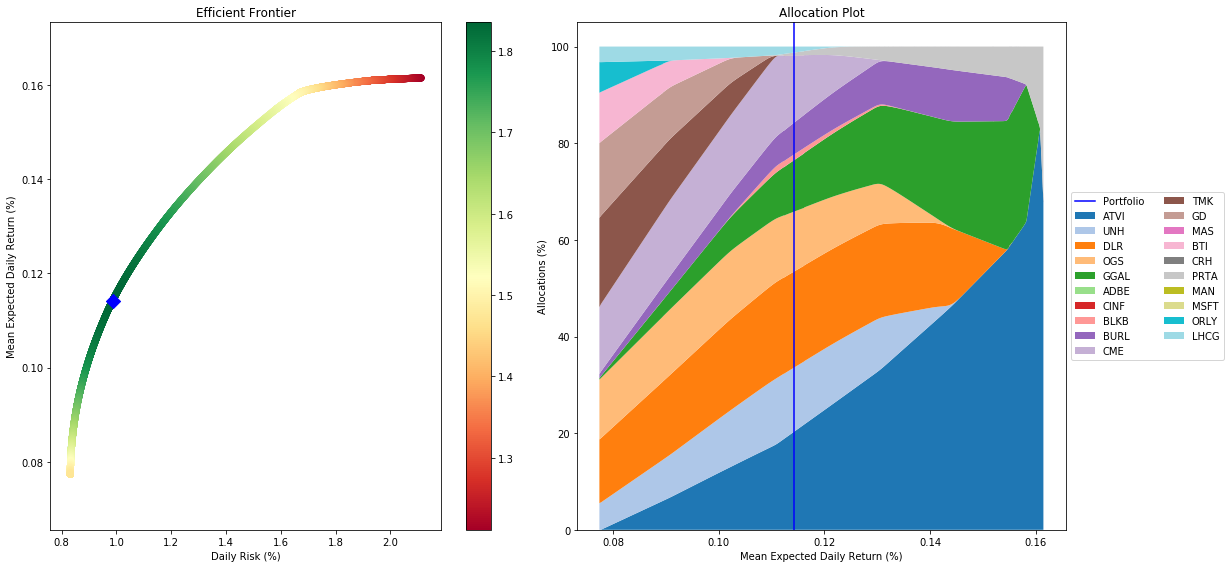

In [43]:
plot_simulations(final_dc_ef_results, final_best_dc_sharpe_index, final_top_dc_stocks)

In [44]:
# Print Disjoint Clique Portfolio
pd.DataFrame([{attr: G_final.node[stock][attr] for attr in ['Name','Category','Exchange','Sharpe','Weight']}
                  for stock in final_top_dc_stocks]).set_index('Name')

,Category,Exchange,Sharpe,Weight
Name,,,,
"Activision Blizzard, Inc.",Multimedia & Graphics Software,NMS,1.147,20.26
UnitedHealth Group Incorporated,Health Care Plans,NYQ,0.915,13.28
"Digital Realty Trust, Inc.",REIT - Office,NYQ,0.895,19.87
"ONE Gas, Inc.",Gas Utilities,NYQ,0.889,12.41
Grupo Financiero Galicia S.A.,Foreign Regional Banks,NCM,0.870,10.61
Adobe Systems Incorporated,Application Software,NMS,0.850,0.02
Cincinnati Financial Corporation,Property & Casualty Insurance,NMS,0.803,0.01
"Blackbaud, Inc.",Business Software & Services,NMS,0.764,1.18
"Burlington Stores, Inc.","Discount, Variety Stores",NYQ,0.741,6.56


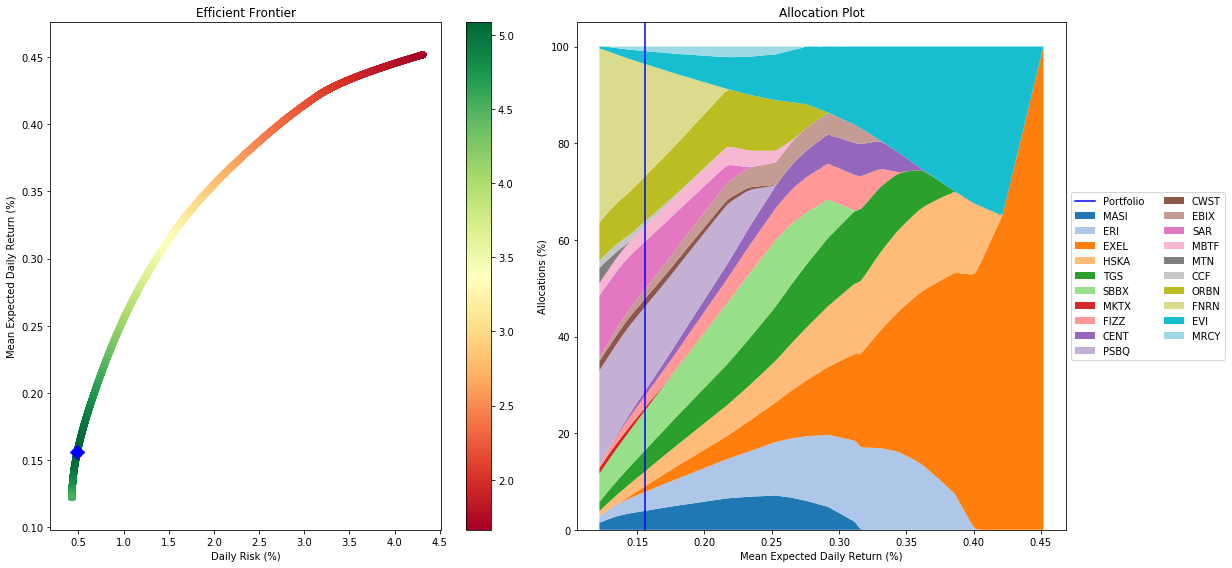

In [45]:
plot_simulations(final_zc_ef_results, final_best_zc_sharpe_index, final_top_zc_stocks)

In [46]:
# Print Zero Centrality Portfolio
pd.DataFrame([{attr: G_final.node[stock][attr] for attr in ['Name','Category','Exchange','Sharpe','Weight']}
                  for stock in final_top_zc_stocks]).set_index('Name')

,Category,Exchange,Sharpe,Weight
Name,,,,
Masimo Corporation,Medical Appliances & Equipment,NMS,1.934,3.92
"Eldorado Resorts, Inc.",Resorts & Casinos,PCX,1.633,3.89
"Exelixis, Inc.",Biotechnology,NMS,1.592,1.16
Heska Corporation,Medical Laboratories & Research,NCM,1.558,3.09
Transportadora de Gas Del Sur S.A.,Gas Utilities,NYQ,1.499,4.34
Sussex Bancorp,Regional - Northeast Banks,NGM,1.469,8.22
MarketAxess Holdings Inc.,Investment Brokerage - National,NMS,1.435,0.56
National Beverage Corp.,Beverages - Soft Drinks,NMS,1.413,2.44
Central Garden & Pet Company,Food - Major Diversified,NMS,1.406,1.03


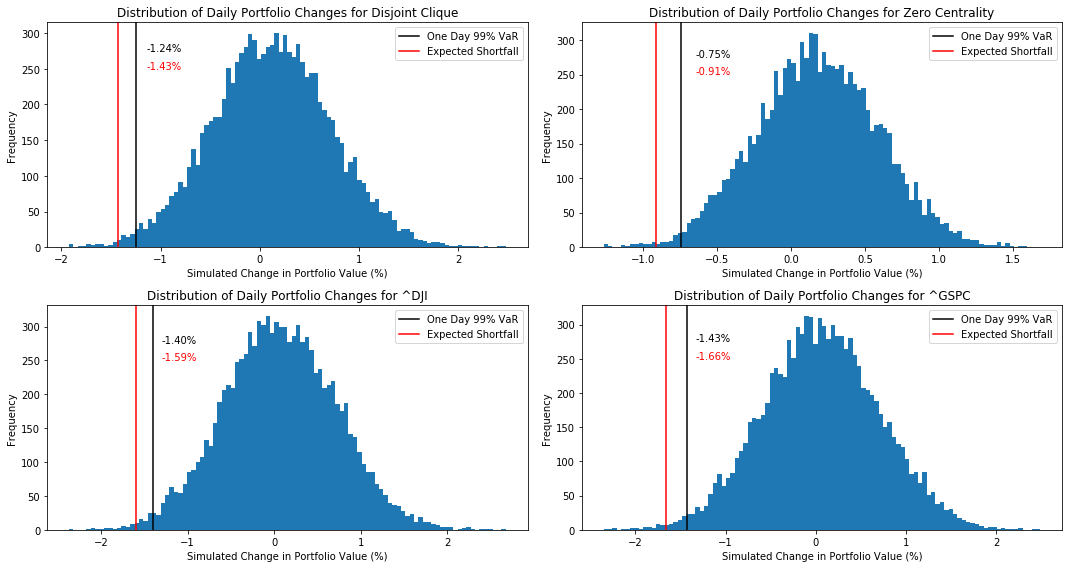

In [51]:
final_dc_VaRs, final_dc_VaR, final_dc_ES = simulate_VaRs(final_top_dc_stocks, final_dc_optimal_weights, 10000)
final_zc_VaRs, final_zc_VaR, final_zc_ES = simulate_VaRs(final_top_zc_stocks, final_zc_optimal_weights, 10000)
DJI_VaRs, DJI_VaR, DJI_ES = simulate_VaRs(['^DJI'], pd.Series(1, index=['^DJI']), 10000)
GSPC_VaRs, GSPC_VaR, GSPC_ES = simulate_VaRs(['^GSPC'], pd.Series(1, index=['^GSPC']), 10000)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(8)
plot_hist(ax1, 'Disjoint Clique', final_dc_VaRs, final_dc_VaR, final_dc_ES)
plot_hist(ax2, 'Zero Centrality', final_zc_VaRs, final_zc_VaR, final_zc_ES)
plot_hist(ax3, '^DJI', DJI_VaRs, DJI_VaR, DJI_ES)
plot_hist(ax4, '^GSPC', GSPC_VaRs, GSPC_VaR, GSPC_ES)
plt.tight_layout()
plt.show()

# Limitations

The limitations of our methods as proposed are many and should be studied further. 

The first and clearest limitation is the lack of sophistication in our selection method employed for our various hyperparameters, including the correlation threshold used to construct the network, the number of stocks selected to comprise each portfolio, and the duration of the training and test periods. A straightforward method for assessing the impact of these choices would be to conduct a sensitivity analysis. 

A second limitation is our universe of ~4,650 stocks. We examined only stocks listed on US exchanges, and thus our methods could benefit from analyzing a broader universe that also includes foreign exchanges. In the same vein, it may also be interesting to assess different asset classes using one network (e.g., equities and bonds). 

A third limitation is our explicit use of the Sharpe Ratio as the screen for final stock selection within both methods. While the metric itself isn't a bad choice, the lack of diveristy in our metrics (also known as factors) is potentially worrisome. Other metrics to assess include value ratios, momentum ratios, and growth ratios. 

# Contact Us

This project was completed by [Florian Singhoff](https://www.linkedin.com/in/florian-singhoff/) and [Chris Becker](https://www.linkedin.com/in/cbecker4/), with help from [Nick Corrie](https://www.linkedin.com/in/nick-corrie/) and [Alex Christian](https://www.linkedin.com/in/alex-christian92/).

Special thanks also to the [Institute for Advanced Analytics](http://analytics.ncsu.edu/) and its faculty. 